In [1]:
from matplotlib import pyplot as plt
from matplotlib import animation

import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns

Compute the Always/Sometimes/Never breakdown on different random graphs

In [29]:
def run_simulation(X, A, n_iter, eps, M, minfriends, minbad):
    Xs = [X]

    for _ in range(n_iter):
        if X.sum() < M:
            # go if enough of your friends went last week
            # whether or not you went
            X = (A.dot(X) > minfriends)
        else:
            X = (A.dot(X) > minbad)

        X += rng.uniform(size=(len(A),1)) < eps
        Xs.append(X)

    return np.hstack(Xs)


def maximal_fixed_point(G):
    g = G.copy()
    while len(g.nodes) > 0:
        k = g.degree()
        to_keep = [node[0] for node in k if node[1] > minfriends]
        if len(to_keep) == len(g.nodes):
            return g
        g = g.subgraph(to_keep)

    return g


def run_simulation_batch(A, n_iter, eps, M, minfriends, minbad, batch_size, rng):
    Xnps = []

    for i in range(batch_size):
        X = rng.uniform(size=(len(A),1)) < 0.3
        Xnps.append(
            run_simulation(X, A, n_iter, eps, M, minfriends, minbad))
        print(f"Ran simulation {i}")

    # count the number of times each node goes to the bar
    # in each batch
    # skip first 50 rounds to give time to settle
    attendance = [np.where(Xnp[:,50:]) for Xnp in Xnps]
    ppl = [pd.Series(a[0]) for a in attendance]

    cnts = pd.DataFrame(index=range(len(A)))
    for i in range(batch_size):
        cnts[i] = ppl[i].value_counts()

    always = (cnts==n_iter - 49).mean(axis=1)
    sometimes = (cnts < n_iter - 49).mean(axis=1)
    never = cnts.isna().mean(axis=1)

    cnts["Always"] = always
    cnts["Sometimes"] = sometimes
    cnts["Never"] = never

    g = maximal_fixed_point(
        nx.convert_matrix.from_numpy_array(A)
    )

    cnts["maximal_fixed_point"] = pd.Series(range(len(A))).apply(
        lambda x: x in g.nodes)

    return cnts

In [99]:
def truncated_power_law(gamma, k_0, n, rng, size=None):
    """
    Generate a sample of size *size* from a power law distribution
    with mininmum *k_0*, maximum *n*, and power *gamma*
    """
    k_0=np.float64(k_0)
    gamma=np.float64(gamma)
    n=np.float64(n)
    
    if size:
        U = rng.uniform(size=size)
    else:
        U = rng.uniform()
        
    return (
        (k_0**(1-gamma) - 
             ( k_0**(1-gamma) - n**(1-gamma) ) * U 
        )**(1/(1-gamma))
    )

def generate_chung_lu(k, rng):
    n = len(k)

    k_mean = k.mean()
    # k_mean times is twice the expected number of edges
    # this will be the denominator of all edge probabilities
    m2 = k_mean * n

    # initialize adjacency matrix
    A = np.zeros((n,n),dtype=int)
    choices = rng.random(n*(n-1) // 2)
    choice_i = 0
    
    for i in range(n):
        for j in range(i+1,n):
            # no self loops
            if i == j:
                continue
                
            # compute probability of edge
            p = min(
                (k[i] * k[j] / m2,
                1))
            
            # generate edge
            if choices[choice_i] < p:
                A[i,j] = 1
                A[j,i] = 1
            
            choice_i += 1
                
    return A




rng = np.random.default_rng(2357111)

gamma = 2
k_0 = 3
n = 100
size=300
n_iter = 1000
eps = 0
M = 60
minfriends = 2
minbad = 5
batch_size = 50

# generate configuration model
k = truncated_power_law(gamma, k_0, n, rng, size=size).astype(int)
k.sort()
A = generate_chung_lu(k, rng)

cnts_cm = run_simulation_batch(A, n_iter, eps, M, minfriends, minbad, batch_size, rng)

10.013333333333334

In [101]:
k_bar = A.sum() / len(A)
n = len(A)
p = k_bar / n

G = nx.gnp_random_graph(n, p)
A = nx.convert_matrix.to_numpy_array(G)

cnts_gnp = run_simulation_batch(A, n_iter, eps, M, minfriends, minbad, batch_size, rng)

Ran simulation 0
Ran simulation 1
Ran simulation 2
Ran simulation 3
Ran simulation 4
Ran simulation 5
Ran simulation 6
Ran simulation 7
Ran simulation 8
Ran simulation 9
Ran simulation 10
Ran simulation 11
Ran simulation 12
Ran simulation 13
Ran simulation 14
Ran simulation 15
Ran simulation 16
Ran simulation 17
Ran simulation 18
Ran simulation 19
Ran simulation 20
Ran simulation 21
Ran simulation 22
Ran simulation 23
Ran simulation 24
Ran simulation 25
Ran simulation 26
Ran simulation 27
Ran simulation 28
Ran simulation 29
Ran simulation 30
Ran simulation 31
Ran simulation 32
Ran simulation 33
Ran simulation 34
Ran simulation 35
Ran simulation 36
Ran simulation 37
Ran simulation 38
Ran simulation 39
Ran simulation 40
Ran simulation 41
Ran simulation 42
Ran simulation 43
Ran simulation 44
Ran simulation 45
Ran simulation 46
Ran simulation 47
Ran simulation 48
Ran simulation 49


In [103]:
cnts_gnp.Always.sum()

15.74

In [104]:
cnts_gnp.Sometimes.sum()

64.74000000000001

In [105]:
cnts_gnp.Never.sum()

219.52

In [108]:
cnts_gnp.maximal_fixed_point.sum()

300

In [140]:
sizes = [100, 100, 100]
probs = [[0.09, 0.01, 0.01], [0.01, 0.09, 0.01], [0.01, 0.01, 0.09]]
G = nx.stochastic_block_model(sizes, probs, seed=3089277)
A = nx.convert_matrix.to_numpy_matrix(G)

cnts_sbm = run_simulation_batch(A, n_iter, eps, M, minfriends, minbad, batch_size, rng)

Ran simulation 0
Ran simulation 1
Ran simulation 2
Ran simulation 3
Ran simulation 4
Ran simulation 5
Ran simulation 6
Ran simulation 7
Ran simulation 8
Ran simulation 9
Ran simulation 10
Ran simulation 11
Ran simulation 12
Ran simulation 13
Ran simulation 14
Ran simulation 15
Ran simulation 16
Ran simulation 17
Ran simulation 18
Ran simulation 19
Ran simulation 20
Ran simulation 21
Ran simulation 22
Ran simulation 23
Ran simulation 24
Ran simulation 25
Ran simulation 26
Ran simulation 27
Ran simulation 28
Ran simulation 29
Ran simulation 30
Ran simulation 31
Ran simulation 32
Ran simulation 33
Ran simulation 34
Ran simulation 35
Ran simulation 36
Ran simulation 37
Ran simulation 38
Ran simulation 39
Ran simulation 40
Ran simulation 41
Ran simulation 42
Ran simulation 43
Ran simulation 44
Ran simulation 45
Ran simulation 46
Ran simulation 47
Ran simulation 48
Ran simulation 49


In [142]:
cnts_sbm.Always.sum()

53.78

In [143]:
cnts_sbm.Sometimes.sum()

9.22

In [144]:
cnts_sbm.Never.sum()

237.0

In [145]:
cnts_sbm.iloc[:100].Always.sum()

13.799999999999999

In [146]:
cnts_sbm.iloc[100:200].Always.sum()

22.0

In [147]:
cnts_sbm.iloc[200:300].Always.sum()

17.980000000000004

In [149]:
cnts_sbm.maximal_fixed_point.sum()

300

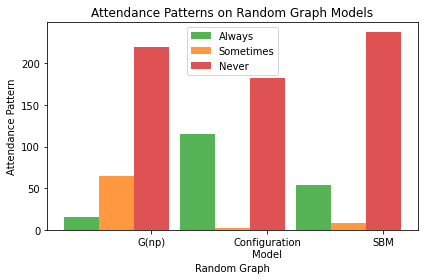

In [160]:
# data to plot
always = (cnts_gnp.Always.sum(), cnts_cm.Always.sum(), cnts_sbm.Always.sum())
sometimes = (cnts_gnp.Sometimes.sum(), cnts_cm.Sometimes.sum(), cnts_sbm.Sometimes.sum())
never = (cnts_gnp.Never.sum(), cnts_cm.Never.sum(), cnts_sbm.Never.sum())

# create plot
# fig, ax = plt.subplots()
index = np.arange(3)
bar_width = 0.3
opacity = 0.8

rects1 = plt.bar(index, always, bar_width,
alpha=opacity,
color='tab:green',
label='Always')

rects2 = plt.bar(index + bar_width, sometimes, bar_width,
alpha=opacity,
color='tab:orange',
label='Sometimes')

rects2 = plt.bar(index + 2*bar_width, never, bar_width,
alpha=opacity,
color='tab:red',
label='Never')

plt.xlabel('Random Graph')
plt.ylabel('Attendance Pattern')
plt.title('Attendance Patterns on Random Graph Models')
plt.xticks(index + 2*bar_width, ('G(np)', 'Configuration\nModel', 'SBM'))
plt.legend()

plt.tight_layout()
plt.show()

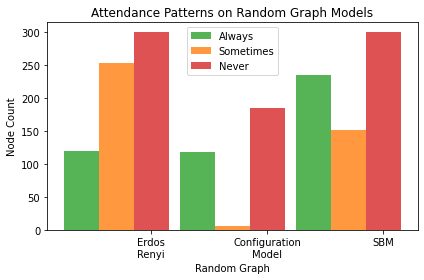

In [175]:
# data to plot
always = ((cnts_gnp.Always > 0).sum(), (cnts_cm.Always > 0).sum(), (cnts_sbm.Always > 0).sum())
sometimes = ((cnts_gnp.Sometimes > 0).sum(), (cnts_cm.Sometimes > 0).sum(), (cnts_sbm.Sometimes > 0).sum())
never = ((cnts_gnp.Never > 0).sum(), (cnts_cm.Never > 0).sum(), (cnts_sbm.Never > 0).sum())

# create plot
# fig, ax = plt.subplots()
index = np.arange(3)
bar_width = 0.3
opacity = 0.8

rects1 = plt.bar(index, always, bar_width,
alpha=opacity,
color='tab:green',
label='Always')

rects2 = plt.bar(index + bar_width, sometimes, bar_width,
alpha=opacity,
color='tab:orange',
label='Sometimes')

rects2 = plt.bar(index + 2*bar_width, never, bar_width,
alpha=opacity,
color='tab:red',
label='Never')

plt.xlabel('Random Graph')
plt.ylabel('Node Count')
plt.title('Attendance Patterns on Random Graph Models')
plt.xticks(index + 2*bar_width, ('Erdos\nRenyi', 'Configuration\nModel', 'SBM'))
plt.legend()

plt.tight_layout()
plt.show()

In [167]:
def not_sometimes(cnts):
    maska = cnts.Always > 0
    maskn = cnts.Never > 0
    masks = cnts.Sometimes == 0
    
    return (maska & maskn & masks).sum()

not_sometimes(cnts_sbm)

96

In [168]:
not_sometimes(cnts_gnp)

0

In [169]:
not_sometimes(cnts_cm)

0